In [4]:
import numpy as np # vectorization and arrays
import pandas as pd # visualization
import random # for randomization
import matplotlib.pyplot as plt # for graphing
import copy # to mutate lists that we want to mutate
import os # to make folder and save files
import streamlit as st # for the GUI
import seaborn as sns # visuals
import math # for sqrt
import glob # images
from PIL import Image # simulation
import json # saving graphs and their cells

In [5]:
def run_experiment(map_num,size = 2):
    """
    Parameters:
    size - an integer to resize the graph if the user
    has a different size screen
    
    Returns:
    The map and the random starting points
    
    Purpose:
    To generate a graph with our different cell typesNorm
    """

    # user can change this value based on the computer screen size (default = 2)
    if int(size) < 0:
        size = 2

    graph_size_x = 100 # pixel size x is double pixel size y
    graph_size_y = 50 # pixel size y is double pixel size x
        
    # size of the figure on the screen
    fig_x = size * (max([graph_size_x,graph_size_y])/min([graph_size_x,graph_size_y])) * 5 # fig x is double fig y
    fig_y = int(fig_x / 2) # fig y is half of fig x
    
    global all_square_coordinates
    # let's see if the all_square_coordinates variable exists
    # if it does we do not intialize it again
    # if it does NOT exist we initialize the variable once to be used throughout
    # every single random graph generation
    try:
        len(all_square_coordinates) # if we can't get the length it doesnt exist
    except: # so let's initialize it
        # generating random x and y coordinates
        x_range = np.arange(0, graph_size_x )
        y_range = np.arange(0, graph_size_y)

        # this double for loop is not O(n^2) it is O(m x n), so it's good - not exponential
        all_square_coordinates = []
        for x_coord in x_range:
            for coordinate_pair in [(x_coord,y) for y in y_range]:
                all_square_coordinates.append(coordinate_pair)
        
    # intializing the fig size (screen size)
    fig_size = (fig_x,fig_y)
    fig = plt.figure()
    fig.set_size_inches(fig_x, fig_y)

    # adding one subplot of our graph (we can add more later)
    ax = fig.add_subplot(1, 1, 1, autoscale_on = False)
    # make the graph 100 x 50 pixels
    ax.scatter([0,100 + 1],[0,50 + 1], color = 'white')
    
    # creating grid lines for x and y
    ax.set_xticks(np.arange(0,graph_size_x + 1))
    ax.set_yticks(np.arange(0,graph_size_y + 1))

    # getting rid of tick labels with an empty list
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # enabling the grid
    ax.grid()

    # calculating size of square to fit the graph
    square_shade_size = fig_x * fig_y / (graph_size_x / graph_size_y)

    # to ensure that we don't randomly pick a cell we have already chosen
    available_coords = copy.deepcopy(all_square_coordinates)
    
    # shuffle our coords 10 times!
    for _ in range(0,10):
        random.shuffle(available_coords)
    
    
    #############################################################################
    # NORMAL CELLS
    normal_cells = available_coords[0:2500]
    
    # getting x and y pairs
    normal_cells_x = np.array([coord[0] for coord in normal_cells])
    normal_cells_y = np.array([coord[1] for coord in normal_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x  y  to center our shaded square on the graph
    normal_cells_ax = ax.scatter(normal_cells_x+.5, normal_cells_y+.5, color = 'orange', s = square_shade_size, marker = ",",
                             label = "Normal Cells")
    #############################################################################
    # HIGHWAY CELLS
    highway_cells = available_coords[2500:3500]

    # getting x and y pairs
    highway_cells_x = np.array([coord[0] for coord in highway_cells])
    highway_cells_y = np.array([coord[1] for coord in highway_cells])
    
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    highway_cells_ax = ax.scatter(highway_cells_x+.5, highway_cells_y+.5, color = 'red', s = square_shade_size, marker = ",",
                             label = "Highway Cells")
    ##############################################################################
    # HARD TO TRAVERSE CELLS
    hard_cells = available_coords[3500:4500]
        
    # getting x and y pairs
    hard_cells_x = np.array([coord[0] for coord in hard_cells])
    hard_cells_y = np.array([coord[1] for coord in hard_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    hard_cells_ax = ax.scatter(hard_cells_x+.5, hard_cells_y+.5, color = 'pink', s = square_shade_size, marker = ",",
                             label = "Hard To Traverse Cells")
    ##############################################################################
    # CHOOSING A RANDOM START CELL
    # plotting the random starting point
    random_pair = random.choice(available_coords[0:4500])
    random_x_start = random_pair[0]
    random_y_start = random_pair[1]
    ##############################################################################
    
    # BLOCKED CELLS, rest of the available coords are now blocked
    blocked_cells = available_coords[4500:5000]
    
    # getting x and y pairs
    blocked_cells_x = np.array([coord[0] for coord in blocked_cells])
    blocked_cells_y = np.array([coord[1] for coord in blocked_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    blocked_cells_ax = ax.scatter(blocked_cells_x+.5, blocked_cells_y+.5, color = 'gray', s = square_shade_size, marker = ",",
                             label = "Blocked Cells")
    ##############################################################################

    starting_point = ax.scatter(random_x_start+.5,random_y_start+.5, color = 'blue', s = square_shade_size * 4.5, marker = '*',
                                   label = "Start")
    
    # remove the exta ticks (making our graph look pretty)
    plt.tick_params(bottom = False, left = False)

    # darken the grid lines
    x_gridlines = ax.get_xgridlines()
    y_gridlines = ax.get_ygridlines()
    for x in x_gridlines:
        x.set_linewidth(size)
    for y in y_gridlines:
        y.set_linewidth(size)
    
    # creating a map with the cells and their corresponding types
    unknown_map = dict()

    counter = 0
    all_cells = [(normal_cells_x,normal_cells_y), (highway_cells_x,highway_cells_y), 
                 (hard_cells_x,hard_cells_y), (blocked_cells_x,blocked_cells_y)]
    
    # iterating through each cell type and creating a map to traverse for testing
    for cell_type in all_cells:
        counter += 1
        if counter == 1:
            cell_string = 'normal'
        elif counter == 2:
            cell_string = 'highway'
        elif counter == 3:
            cell_string = 'traverse'
        elif counter == 4:
            cell_string = 'blocked'
        for x,y in zip(cell_type[0],cell_type[1]):
            unknown_map[(x,y)] = cell_string 
            
    map_number = 0
    
    ground_truth, observations, action_type, curr_graph_data = random_actions(random_pair, unknown_map, map_num)        
    
    path_ax = ax.scatter(np.array([x[0] for x in ground_truth])+0.50, np.array([y[1] for y in ground_truth])+0.50, color = 'black', s = square_shade_size, marker = ".",
                             label = "Random Path", alpha = 1.00)
    
     # creating handles
    handles = [blocked_cells_ax,normal_cells_ax,highway_cells_ax,hard_cells_ax,
               starting_point,path_ax]

    # legend for labels
    ax.legend(handles = handles)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,prop={'size': size * 10})
    
    plt.savefig(f"MAP {map_num} IMAGE.jpg")
    plt.close('all')
    
    new_map = dict()
    # update axis and create a new map
    for key in unknown_map:
        # saving value and deleting the key
        value = unknown_map[key]
        
        # swapping coordinates
        key = (abs(key[1]-49),key[0])
        
        new_map[key] = value
    
    # saving graph data
    with open(f'GRAPH {map_num} DATA.json', 'w') as fp:
        json.dump(str(new_map), fp)
    
    curr_graph_data[map_num]
    
    return curr_graph_data, new_map

In [6]:
def random_actions(start, unknown_map, map_number):
    """
    Parameters:
    start - two integers that denote our start position
    unknown_map - a dictionary containing all the points in our graph
    and the corresponding cell type
    map_number - an integer that incremements every time this function is run
    
    Returns:
    ground_truth - a list containing the traveled to points
    observations - a list containing our sensor reading data
    action_type - a list containing what actions we took
    
    Purpose:
    To simulate random up, down, left, right movements 
    and save metrics in a file
    """
    # specifying the actions and the keys associated with it
    actions = {"Up":1, "Left":-1, "Down": -1, "Right": 1}
    action_keys = list(actions.keys())

    folder_name = "Map " + str(map_number)
    os.mkdir(folder_name)
    file_counter = 0

    # to hold all randomness
    curr_graph_data = {map_number:[]}
    
    # loop 10 times
    for _ in range(0,10):
        # setting up the empty lists except for the ground truth labels
        ground_truth = [start]
        observations = []
        action_type = []

        # getting the same start values
        pos_x, pos_y = start

        # increment counter
        file_counter += 1

        # running a random iteration of 100 actions
        for _ in range(0,100):

            # choosing a random movement (Up, Left, Down, Right)
            random_choice = random.choice(action_keys)
            random_action = actions[random_choice]

            # we excute the correct thing 90% of the time, so...
            if (np.random.choice([True,False], p = [0.90,0.10])):

                try:
                    # updating our current position
                    if random_choice == "Up" and unknown_map[(pos_x,pos_y + 1)] != 'blocked':
                        pos_y += 1
                    elif random_choice == "Left" and unknown_map[(pos_x - 1,pos_y)] != 'blocked':
                        pos_x -= 1
                    elif random_choice == "Down" and unknown_map[(pos_x,pos_y - 1)] != 'blocked':
                        pos_y -= 1
                    elif random_choice == "Right" and unknown_map[(pos_x + 1,pos_y)] != 'blocked':
                        pos_x += 1
                except Exception as e:
                    # if we error that means that we are out of bounds and we should NOT
                    # update anything
                    pass

            # updating the position with the current x and y coords
            current_position = (pos_x, pos_y)

            # getting cell type
            cell_type = unknown_map[current_position]

            # cell types
            possible_types = ["normal","traverse","highway"]

            # delete the type of the current_position
            del possible_types[possible_types.index(cell_type)]
            # getting the sensor reading randomly
            sensor_reading = np.random.choice([cell_type,possible_types[0],possible_types[1]], p = [0.90,0.05,0.05])[0].upper()

            # getting the action letter type, first letter and make it capital
            action_letter = random_choice[0].upper()

            # saving the data - in memory
            ground_truth.append(current_position)
            observations.append(sensor_reading)
            action_type.append(action_letter) 
        
        # STILL HAVE TO FLIP THE X AND Y AXIS 
        
        # creating the file in the directory
        filename = "groundTruth" + str(file_counter) + ".txt"
        path = r"Map " + str(map_number) + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, filename), 'wb') as temp_file:
            pass
        
        # saving the data in a file
        file = open(path + filename, "a+")
        
        # swapping axis because of the file description
        ground_truth_to_write = swap_axis(ground_truth)
        
        no_line_counter = 0
        for data in [ground_truth_to_write,observations,action_type]:
            no_line_counter += 1
            for numbers in data:
                if no_line_counter == 1:
                    file.write(f"{numbers[0]} {numbers[1]}\n")
                else:
                    file.write(numbers + "\n")
            if no_line_counter != 3:
                file.write("\n")
        file.close()
        
        curr_graph_data[map_number].append([ground_truth,observations,action_type])
    
    return ground_truth, observations, action_type, curr_graph_data

In [7]:
def swap_axis(points):
    """
    Parameters:
    points - a 2d list containing x and y points
    
    Returns: 
    swapped_axis - a new list with swapped axis
    
    Purpose:
    In the project we use a different coordinate system
    where (y,x) and the origin starts from the top left corner
    This function just takes every point and maps it accordingly
    to the project description
    """
    swapped_axis = []

    for x,y in zip([x[0] for x in points],[y[1] for y in points]):
        y = abs(y - 49)
        swapped_axis.append((y,x))
        
    return swapped_axis

In [8]:
def save_fig(map_num, t, predictions, max_key, i):
    """
    To save our figure in a heatmap based on our predictions.
    We have the images to later put them into an animated gif.
    """
    
    # let's display our final predictions
    for coords in predictions:
        x, y = coords
        heatmap_probs[x][y] = predictions[(x, y)]

    # displaying figure
    plt.figure(figsize = (20,8))
    plt.title(f"Map {map_num}")

    # displaying heatmap
    ax = sns.heatmap(heatmap_probs)

    # plotting current point
    current_point = ax.scatter(x = ground_truth[t+1][1], y = ground_truth[t+1][0], 
                                color = 'blue', s = 500, 
                                marker = '*', label = "Current Point")

    maximum_prediction = ax.scatter(x = max_key[1], y = max_key[0],
                                   color = 'yellow', s = 500,
                                   marker = "*", label = "Prediction")

     # creating handles
    handles = [current_point, maximum_prediction]

    # legend for labels
    ax.legend(handles = handles)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=len(handles),prop={'size': 2 * 10})

    # saving the figure in the specified directory
    plt.savefig(r"C:\Users\hgrop\Desktop\Rutgers\INTRO TO AI\Project 2\Animations\Map " + str(map_num) + r" - images\randomWalks" + str(i+1) + "\\t("+ str(i) + ")=" + str(t) + ".jpg")
    plt.close('all')
    
def make_initial_state_distribution(map_num, ground_truth, i):
    """
    Makes the current initial state distribution and 
    creates/saves day 0 of our simulation
    """
    # swapping axis of ground_truth to match our coordinate system
    ground_truth = swap_axis(ground_truth)

    # initialize a 100 x 50 array with zeros
    # each space in the 2d array represents a cell in the graph
    heatmap_probs = np.zeros((50,100))

    # let's make an intial state distribution of the cells we can be on
    # because we do not know where we are initially, so we take the (number of cells) / (total cells - blocked cells)
    cell_types = list(the_map.values())

    # deleting blocked cells
    cell_types = [x for x in cell_types if x != "blocked"]

    # num of cells without blocked cells in our graph
    num_possible_cells = len(cell_types)

    # to hold our intial probabilties
    initial_state_distribution = dict()

    for cell in set(cell_types):
        initial_state_distribution[cell] = (num_possible_cells / 5000)

    # let's apply our intial state distribution to the heat map
    for coords, cell_type in the_map.items():
        if cell_type != "blocked":
            x, y = coords
            heatmap_probs[x][y] = initial_state_distribution[cell_type]
            
    # saving the figure
    plt.figure(figsize = (20,8))
    ax = sns.heatmap(heatmap_probs)
    plt.savefig(r"C:\Users\hgrop\Desktop\Rutgers\INTRO TO AI\Project 2\Animations\Map " + str(map_num) + r" - images\randomWalks" + str(i+1) + "\\t("+ str(i) + ")=" + str(0) + ".jpg")
    plt.close('all')
            
    return ground_truth, initial_state_distribution, heatmap_probs

def make_transition_model():
    """
    Makes the transition model for each position in the graph
    """
    # creating a variable to hold our possible positions
    X = [x for x in the_map if the_map[x] != 'blocked']

    # making our transition model
    transition_model = dict()

    # to make this transition model I am using np.linalg.norm()
    # to calculate the distances from a point to another point
    # if the distance is 1 there is a possibility we can get that point
    # if it is zero we are in the same place
    # anything else is a no probability of getting to that point

    # this implementation is vectorized to speed up the computation time!

    X_array = np.array(X)
    X_len = len(X)

    # i and j denote indices
    for point in X_array:

        # creating an array with same length as X
        temp_array = np.array([point] * X_len)

        # holds the euclidean distance between that 'point'
        # and all the other points in X
        vals = np.linalg.norm(np.abs(X_array - temp_array), axis = 1)

        # lets get the indicies of the values from
        # distance 1 and 0
        d1 = list(np.where(vals == 1))[0]
        d0 = list(np.where(vals == 0))[0]

        point = (point[0],point[1])
        # iterate through lists and assign the values
        for index in d1:
            next_point = (X[index][0],X[index][1])
            # 90% chance to move to a point we can reach
            transition_model[(point, next_point)] = 0.90

        # iterate through lists and assign the values
        for index in d0:
            next_point = (X[index][0],X[index][1])
            # 10% chance to move to stay in the same place
            transition_model[(point, next_point)] = 0.10

    return transition_model, X

def make_predictions_and_save_images(map_num, X, i):
    """
    Makes predictions based on our observations
    and saves our images of heatmaps in folder(s)
    """

    # to hold all calculated errors
    error_list = []

    # to hold ground truth probabilities
    ground_truth_probs = []

    # predictions for each possible position based on the evidence
    predictions = dict()

    # initializing each key in prior beliefs
    for point in X:
        # at first our prior belief is zero 
        predictions[point] = 0

    # predicting day t + 2
    for t in range(0,99):
        # getting evidence up to that day
        evidence = [[act,obs] for (act,obs) in zip(action_type[:t+1], observations[:t+1])]

        # iterating ocer all coordinates and given evidence up to day t + 1
        for coord in X:
            # start at one because we are multiplying values
            # also keeping track of probabilities iterating over Xt
            current_prob = 1 

            for action, sensor_type in evidence:
                # reading the most recent evidence
                # unpacking our coordinates
                x, y = coord

                # what action are we taking?
                if action == "U":
                    # updating coordinate based on action 
                    new_coord = (x-1, y)
                elif action == "D":
                    # updating coordinate based on action 
                    new_coord = (x+1, y)
                elif action == "R":
                    # updating coordinate based on action 
                    new_coord = (x, y+1)
                elif action == "L":
                    # updating coordinate based on action 
                    new_coord = (x, y-1)

                # what if the new coordinate is out of bounds?
                # what if the new coorindate is a blocked cell? DNE -> does not exist
                if the_map.get(new_coord, 0) == 'blocked' or the_map.get(new_coord, 'DNE') == 'DNE':
                    # set the new coordinate to the old coordinates
                    new_coord = coord

                # let's get the cell type of the new coorindate
                cell_type = the_map[new_coord][0].upper()

                # PRIOR BELIEFS
                # probability that the current cell_type == sensor?
                if cell_type == sensor_type:
                    # 90% chance we sense the correct cell
                    current_prob *= 0.90
                else:
                    # 10% chance we sense another cell
                    current_prob *= 0.10


                # TRANSITION MODEL - prob from moving from old coord to new coord
                transition_probability = transition_model[(coord),(new_coord)]
                current_prob *= transition_probability

                # let's update the predictions in our predictions dictionary!
                predictions[new_coord] += current_prob

                # now make the new coordinate our old coordinate
                coord = new_coord

        # multiplying by our observational model
        for coords in predictions:

            next_cell_type = the_map[coords][0].upper()

            if next_cell_type != observations[t+1]:
                # then it is IMPOSSIBLE that we are in that cell!
                predictions[coords] *= 0
            else:
                # it is possible!
                # 90% chance we are randomly in one of those cells
                predictions[coords] *= 0.90


        # calculating alpha and applying it to the predictions
        alpha = 1 / (np.sum(list(predictions.values())))
        for coords in predictions:
            predictions[coords] *= alpha

        # getting the max prediction in the prediction dictionary
        vals = list(predictions.values())
        index = vals.index(max(vals))
        max_key = list(predictions.keys())[index]
        max_prediction = predictions[max_key]

        # calculating the error using the math.dist() (distance)
        error = math.dist(ground_truth[t+1+1],max_key)
        error_list.append(error)

        # adding ground truth probs to a list
        ground_truth_probs.append(predictions.get(ground_truth[t+1+1], 0))

        # saving the figure after each iteration of t (each day)
        save_fig(map_num, t+1, predictions, max_key, i)
        
    return predictions, ground_truth_probs, error_list

def make_gif(map_num, i):
    """
    Make a gif based with the saved images
    This is an animation!
    """
    
    frame_folder = r"C:\Users\hgrop\Desktop\Rutgers\INTRO TO AI\Project 2\Animations\Map " + str(map_num) + r" - images\randomWalks" + str(i + 1)
    
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
    
    frame_one = frames[0]
    
    frame_one.save("MAP " + str(map_num) + "-" + str(i) + " ANIMATION.gif", format = "GIF", append_images = frames,
               save_all = True, duration = 150, loop = 1)

In [ ]:
# to hold all info regarding maps
map_info = dict()

for map_num in range(1,10+1):
    # generating a random grid w/starting point and the map
    curr_graph_data, the_map = run_experiment(map_num)

    # for each set of random steps in the current map
    data = curr_graph_data[map_num]
    for i in range(0,len(data)):
        ground_truth = data[i][0]
        observations = data[i][1]
        action_type = data[i][2]

        # making our initial state distribution
        ground_truth, initial_state_distribution, heatmap_probs = make_initial_state_distribution(map_num, ground_truth, i)
        # making the transition model
        transition_model, X = make_transition_model()
        # making predictions
        predictions, ground_truth_probs, error_list = make_predictions_and_save_images(map_num, X, i)
        # making simulation
        make_gif(map_num, i)

        # saving outputdata for each map to analyze later
        map_info[(map_num,i)] = (predictions, ground_truth_probs, error_list)
        
        # just showing error
        print((map_num,i))
        plt.plot([np.mean(error_list[:i+1]) for i in range(0,len(error_list))])
        plt.show()
        
    

In [9]:
# making graphs and stuff for problem 5
map_keys = list(map_info.keys())

# getting all probs on ground truth labels
initial_probs = np.zeros(99)
# probabilities for ground truth cells
for key in map_keys:
    initial_probs += np.array(map_info[key][1])
    
# getting all probs on ground truth labels
initial_error = np.zeros(99)
# probabilities for ground truth cells
for key in map_keys:
    initial_error += np.array(map_info[key][2])
    
initial_probs = initial_probs / 99
initial_error = initial_error / 99

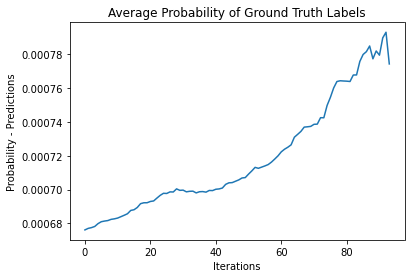

In [25]:
plt.plot([np.mean(initial_probs[:i+1]) for i in range(0,len(initial_probs))])
plt.title("Average Probability of Ground Truth Labels")
plt.ylabel("Probability - Predictions")
plt.xlabel("Iterations")
plt.show()

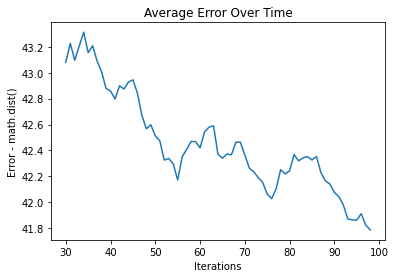

In [22]:
plt.plot([np.mean(initial_error[:i+1]) for i in range(0,len(initial_error))])
plt.title("Average Error Over Time")
plt.ylabel("Error - math.dist()")
plt.xlabel("Iterations")
plt.savefig("Average Error.jpg")